In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [3]:
from langchain_openai import ChatOpenAI

llm=ChatOpenAI(model='o4-mini')

In [4]:
llm.invoke("Hello how are you?")

AIMessage(content='Hello! I’m doing well, thank you. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 11, 'total_tokens': 46, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-Bml7ttF2opMWrlccnmTSqU1eSet9u', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--5903b9d8-1d74-4214-b6c0-bb2f902af099-0', usage_metadata={'input_tokens': 11, 'output_tokens': 35, 'total_tokens': 46, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
from langgraph.types import Command # used to send command to one agent to another

In [6]:
from langgraph.prebuilt import create_react_agent

In [7]:
def add_number(state):
    result=state["num1"] + state["num2"]
    print(f"Addition is {result}")
    return Command(update=result,goto="multiply")

In [8]:
state={"num1":10,"num2":20}

In [9]:
add_number(state)

Addition is 30


Command(update=30, goto='multiply')

In [10]:
from langchain_core.tools import tool

In [11]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent to help"""
    return "multiple_agent_output"

In [12]:
@tool
def transfer_to_addition_expert():
    """Ask addition Agent for help"""
    return "addition_agent_output"

In [13]:
llm_with_tool=llm.bind_tools([transfer_to_multiplication_expert])

In [14]:
response=llm_with_tool.invoke("Hi")

In [15]:
response.content

'Hello! How can I assist you today?'

In [16]:
response.tool_calls

[]

In [29]:
response=llm_with_tool.invoke("What is sum of 2 and 2?")

In [30]:
response.content

'The sum of 2 and 2 is 4.'

In [31]:
response.tool_calls

[]

In [46]:
from typing_extensions import Literal
from langgraph.graph.message import MessagesState

In [47]:
from langgraph.graph import START,StateGraph, END

In [61]:
###Agent 1
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_agent","__end__"]]:
    system_prompt=("""
                You are an addition expert, you can ask the multiplication expert for help with multiplication.
                   Always do your portion of calculation before handoff.
                """)
    messages=[{"role":"system","content": system_prompt }]+state["messages"]
    ai_msg=llm_with_tool.invoke(messages)
    if len(ai_msg.tool_calls)>0:
        tool_call_id=ai_msg.tool_calls[-1]['id']
        tool_msg={
            "role":"tool",
            "content": "successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(goto="multiplication_agent",update={"messages":[ai_msg,tool_msg]})
    return {"messages":[ai_msg]}

In [62]:
##Agent 2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_agent","__end__"]]:
    system_prompt=("""
                You are an multiplication expert, you can ask the addition expert for help with addition.
                   Always do your portion of calculation before handoff.
                """)
    messages=[{"role":"system","content": system_prompt }]+state["messages"]
    ai_msg=llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    if len(ai_msg.tool_calls)>0:
        tool_call_id=ai_msg.tool_calls[-1]['id']
        tool_msg={
            "role":"tool",
            "content": "successfully transferred",
            "tool_call_id": tool_call_id
        }
        return Command(goto="additional_agent",update={"messages":[ai_msg,tool_msg]})
    return {"messages":[ai_msg]}

In [63]:
graph=StateGraph(MessagesState)

In [64]:
graph.add_node("additional_agent",additional_expert)

In [65]:
graph.add_node("multiplication_agent",multiplication_expert)

In [66]:
graph.add_edge(START,"additional_agent")

In [67]:
app=graph.compile()

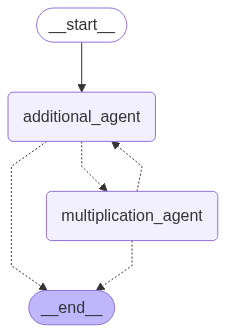

In [68]:
from IPython.display import display,Image

display(Image(app.get_graph().draw_mermaid_png()))

In [70]:
app.invoke({"messages":[("user","what is (3*5)+12?")]})

{'messages': [HumanMessage(content='what is (3*5)+12?', additional_kwargs={}, response_metadata={}, id='9cb56a7a-f79c-425c-94f3-bbd85003638d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tIgQmMmWlwJKheyy1u67p3ZP', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 728, 'prompt_tokens': 84, 'total_tokens': 812, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 704, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-BmwYJYgx3XfWBMCJT0QhVJWd37Q2S', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f0bcb1f1-c3b7-43dd-a5d7-1ef0ccefcd32-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_tIgQmMmW

## With Real time tool

In [71]:
from langchain_community.tools import DuckDuckGoSearchRun

web_search=DuckDuckGoSearchRun()

In [72]:
web_search.invoke("Who is PM of India?")

"List of all Prime Ministers of India till 2025: Narendra Modi is the current and 14th Prime Minister of India who assumed office on 10 June 2024. India follows a parliamentary system in which the prime minister is the presiding head of the government and chief of the executive of the government. In such systems, the head of state, or, the head of state's official representative (i.e., the monarch, president, or governor-general) usually holds a purely ceremonial position and acts—on most matters—only on the advice of the prime ... Prime Minister Shri Narendra Modi chaired the 48th meeting of PRAGATI, the ICT-enabled, multi-modal platform aimed at fostering Pro-Active Governance and Timely Implementation, by seamlessly integrating efforts of the Central and State governments, at South Block, earlier today. The list of Indian Prime Ministers begins with Jawaharlal Nehru, who became the first Prime Minister in 1947 and consist Jawaharlal Nehru is the longest-serving Prime Minister of Ind

In [73]:
from langchain_experimental.utilities import PythonREPL

In [74]:
repl=PythonREPL()

In [77]:
code="""
x=5
y=x * 2
print(y)
"""

In [78]:
repl.run(code)

'10\n'

In [79]:
from typing import Annotated

In [80]:
@tool
def python_repl_tool(code: Annotated[str, "The python code to execute to generate your chart."]):
    """Use this to execute the python code . If you want to see the output of a value ,
    you should print it out with print(...). This is visible to the user."""
    try:
        result=repl.run(code)
    except Exception as e:
        return f" failed to execute . Error: {repr(e)}"
    result_str=f"Successfully executed :\n \'\'\'python\n{code}\n\'\'\'\nStdout:{result}"
    return (
        result_str+ "\n\n If you have completed all tasks, respond with FINAL ANSWER"
    )

In [81]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute the python code . If you want to see the output of a value ,\n    you should print it out with print(...). This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x000001FF999C5440>)

In [82]:
print(python_repl_tool.invoke(code))

Successfully executed :
 '''python

x=5
y=x * 2
print(y)

'''
Stdout:10


 If you have completed all tasks, respond with FINAL ANSWER


In [83]:
from langgraph.graph import StateGraph,START,END

In [95]:
def make_system_prompt(instruction:str)-> str:
    return (
        "You are a helpful AI assistant , collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        "If you are unable to fully answer , that's ok, another assistant with different tools."
        "will help where you left off. Execute what you can to make progress."
        "If you or any other assistants have the final answer or deliverable,"
        "prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [98]:
from langchain_core.messages import BaseMessage,HumanMessage

In [97]:
def get_next_node(last_message: BaseMessage,goto:str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

In [123]:
def research_node(state:MessagesState)->Command[Literal["chart_generator",END]]:
    research_agent=create_react_agent(llm,
                       tools=[web_search],
                       prompt=make_system_prompt(
                           "you can only do research. you are working with a chart generator colleague."
                       ))
    result=research_agent.invoke(state)
    #result=result["messages"][-1]

    goto=get_next_node(result["messages"][-1],"chart_generator")
    result["messages"][-1]=HumanMessage(content=result["messages"][-1].content,name="researcher")
    return Command(update={"messages":result["messages"]},goto=goto)

In [124]:
def chart_node(state:MessagesState)->Command[Literal["researcher",END]]:
    chart_agent=create_react_agent(llm,
                       tools=[python_repl_tool],
                       prompt=make_system_prompt(
                           "you can only generate chart. you are working with a researcher colleague."
                       ))
    result=chart_agent.invoke(state)
    #result=result["messages"][-1]
    
    goto=get_next_node(result["messages"][-1],"researcher")
    result["messages"][-1]=HumanMessage(content=result["messages"][-1].content,name="chart_generator")
    return Command(update={"messages":result["messages"]},goto=goto)

In [125]:
workflow=StateGraph(MessagesState)

In [126]:
workflow.add_node("researcher",research_node)
workflow.add_node("chart_generator",chart_node)
workflow.add_edge(START,"researcher")
app=workflow.compile()

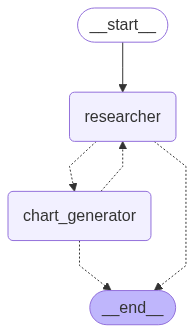

In [127]:
display(Image(app.get_graph().draw_mermaid_png()))

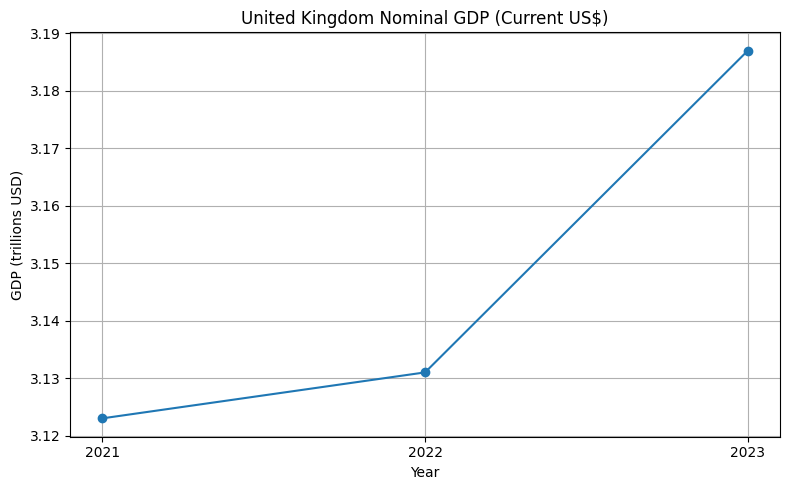

{'messages': [HumanMessage(content="get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='290dc7a0-7642-477e-b463-f2439ef1ffc9'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HmCBpvv058TUVmpkrCms13HZ', 'function': {'arguments': '{"query":"World Bank UK GDP 2021 2022 2023 current USD"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1064, 'prompt_tokens': 198, 'total_tokens': 1262, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 1024, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'o4-mini-2025-04-16', 'system_fingerprint': None, 'id': 'chatcmpl-Bn9lSSEUJ96sDqQHfT3q5h8RkiuaJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c93bf

In [128]:
app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})

In [ ]:
app.invoke({"messages": [("user","")]})